# Active Session 5: Transport Phenomena with GNN

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Simulate Complex Flows with Graph Networks

In this week, we will explore an application of GNN on free surface flows.  

We will go over the implementation of a recent work we had previously discussed in the lecture "[Learning to Simulate Complex Physics with Graph Networks](https://arxiv.org/abs/2002.09405)". 

In the original study comes from DeepMind and utilizes the Graph Net library we discussed in our last exercise. We will go over its implementation and how GraphNet is used to solve a complex fluid flow problem.

You may access the code from [here](https://github.com/deepmind/deepmind-research). 






## Required libraries


In [1]:
pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 37kB/s 
     |████████████████████████████████| 3.8MB 30.4MB/s 
     |████████████████████████████████| 512kB 41.0MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=695e5ba8d5b43879fd04d022544a7f93ad9fc77d8b9a6d8678cb05655836e192
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

### Connecting Google Drive

In [2]:
#Mounting the folder 
# In my case, I created a folder under my drive: My Drive >DDE_2 > GNN
#This is why I will pass this folder structure with a symbolic link
#https://www.freecodecamp.org/news/symlink-tutorial-in-linux-how-to-create-and-remove-a-symbolic-link/
#
#Lets first mount the drive as gdrive:
from google.colab import drive
drive.mount('/content/gdrive')
%ls

Mounted at /content/gdrive
gdrive/  sample_data/


In [3]:
#Now creating the symbolic link:
!ln -s /content/gdrive/My\ Drive/DDE_2/GNN/ /mydrive
!ls /mydrive/

functions  GNN	modelCheckpoint  requirements.txt  rollouts  WaterDrop


In [4]:
!bash pip install -r /mydrive/requirements.txt

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 665kB 7.6MB/s 
     |████████████████████████████████| 2.5MB 19.5MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-cp37-none-any.whl size=91856 sha256=4bba8e608d9500aebc59cdeb880e4a987c8425c1a465b3ea58f2c033a6f71a39
  Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
Successfully built graph-nets
ERROR: gym 0.17.3 has requirement cloudpickle<1.7.0,>=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: tensorflow-probability 0.12.1
    Uninstalling tensorflow-probability-0.12.1:
      Successfully uninstalled tensorflow-probability-0.12.1


In [5]:
# Importing libraries
#-------------------------
import graph_nets as gn
import sonnet as snt
import functools
import numpy as np
import tensorflow.compat.v1 as tf

import collections
import json
import os
import pickle
import tree
import matplotlib.pyplot as plt
from matplotlib import animation
from absl import app
from absl import flags
from absl import logging
from sklearn import neighbors

import collections
import functools
import json
import os
import pickle

In [6]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [7]:
#Importing local functions & utilities
%cd /mydrive
!cp -r functions /content/
%cd /content

/content/gdrive/My Drive/DDE_2/GNN
/content


In [8]:
import sys
sys.path.append('/content/functions')

from functions import reading_utils
from functions import graph_network
from functions import connectivity_utils
from functions import learned_simulator
from functions import noise_utils


### Loading data: reading utilities

In [9]:
# Create a description of the features.
_FEATURE_DESCRIPTION = {
    'position': tf.io.VarLenFeature(tf.string),
}

_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT = _FEATURE_DESCRIPTION.copy()
_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT['step_context'] = tf.io.VarLenFeature(
    tf.string)

_FEATURE_DTYPES = {
    'position': {
        'in': np.float32,
        'out': tf.float32
    },
    'step_context': {
        'in': np.float32,
        'out': tf.float32
    }
}

_CONTEXT_FEATURES = {
    'key': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'particle_type': tf.io.VarLenFeature(tf.string)
}


def convert_to_tensor(x, encoded_dtype):
  if len(x) == 1:
    out = np.frombuffer(x[0].numpy(), dtype=encoded_dtype)
  else:
    out = []
    for el in x:
      out.append(np.frombuffer(el.numpy(), dtype=encoded_dtype))
  out = tf.convert_to_tensor(np.array(out))
  return out


def parse_serialized_simulation_example(example_proto, metadata):
  """Parses a serialized simulation tf.SequenceExample.

  Args:
    example_proto: A string encoding of the tf.SequenceExample proto.
    metadata: A dict of metadata for the dataset.

  Returns:
    context: A dict, with features that do not vary over the trajectory.
    parsed_features: A dict of tf.Tensors representing the parsed examples
      across time, where axis zero is the time axis.

  """
  if 'context_mean' in metadata:
    feature_description = _FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT
  else:
    feature_description = _FEATURE_DESCRIPTION
  context, parsed_features = tf.io.parse_single_sequence_example(
      example_proto,
      context_features=_CONTEXT_FEATURES,
      sequence_features=feature_description)
  for feature_key, item in parsed_features.items():
    convert_fn = functools.partial(
        convert_to_tensor, encoded_dtype=_FEATURE_DTYPES[feature_key]['in'])
    parsed_features[feature_key] = tf.py_function(
        convert_fn, inp=[item.values], Tout=_FEATURE_DTYPES[feature_key]['out'])

  # There is an extra frame at the beginning so we can calculate pos change
  # for all frames used in the paper.
  position_shape = [metadata['sequence_length'] + 1, -1, metadata['dim']]

  # Reshape positions to correct dim:
  parsed_features['position'] = tf.reshape(parsed_features['position'],
                                           position_shape)
  # Set correct shapes of the remaining tensors.
  sequence_length = metadata['sequence_length'] + 1
  if 'context_mean' in metadata:
    context_feat_len = len(metadata['context_mean'])
    parsed_features['step_context'] = tf.reshape(
        parsed_features['step_context'],
        [sequence_length, context_feat_len])
  # Decode particle type explicitly
  context['particle_type'] = tf.py_function(
      functools.partial(convert_fn, encoded_dtype=np.int64),
      inp=[context['particle_type'].values],
      Tout=[tf.int64])
  context['particle_type'] = tf.reshape(context['particle_type'], [-1])
  return context, parsed_features


def split_trajectory(context, features, window_length=7):
  """Splits trajectory into sliding windows."""
  # Our strategy is to make sure all the leading dimensions are the same size,
  # then we can use from_tensor_slices.

  trajectory_length = features['position'].get_shape().as_list()[0]

  # We then stack window_length position changes so the final
  # trajectory length will be - window_length +1 (the 1 to make sure we get
  # the last split).
  input_trajectory_length = trajectory_length - window_length + 1

  model_input_features = {}
  # Prepare the context features per step.
  model_input_features['particle_type'] = tf.tile(
      tf.expand_dims(context['particle_type'], axis=0),
      [input_trajectory_length, 1])

  if 'step_context' in features:
    global_stack = []
    for idx in range(input_trajectory_length):
      global_stack.append(features['step_context'][idx:idx + window_length])
    model_input_features['step_context'] = tf.stack(global_stack)

  pos_stack = []
  for idx in range(input_trajectory_length):
    pos_stack.append(features['position'][idx:idx + window_length])
  # Get the corresponding positions
  model_input_features['position'] = tf.stack(pos_stack)

  return tf.data.Dataset.from_tensor_slices(model_input_features)

### Connectivity utilities

In [10]:
def _compute_connectivity(positions, radius):
  """Get the indices of connected edges with radius connectivity.

  Args:
    positions: Positions of nodes in the graph. Shape:
      [num_nodes_in_graph, num_dims].
    radius: Radius of connectivity.

  Returns:
    senders indices [num_edges_in_graph]
    receiver indices [num_edges_in_graph]

  """
  tree = neighbors.KDTree(positions)
  receivers_list = tree.query_radius(positions, r=radius)
  num_nodes = len(positions)
  senders = np.repeat(range(num_nodes), [len(a) for a in receivers_list])
  receivers = np.concatenate(receivers_list, axis=0)
  return senders, receivers


def _compute_connectivity_for_batch(positions, n_node, radius):
  """`compute_connectivity` for a batch of graphs.

  Args:
    positions: Positions of nodes in the batch of graphs. Shape:
      [num_nodes_in_batch, num_dims].
    n_node: Number of nodes for each graph in the batch. Shape:
      [num_graphs in batch].
    radius: Radius of connectivity.

  Returns:
    senders indices [num_edges_in_batch]
    receiver indices [num_edges_in_batch]
    number of edges per graph [num_graphs_in_batch]

  """

  # TODO(alvarosg): Consider if we want to support batches here or not.
  # Separate the positions corresponding to particles in different graphs.
  positions_per_graph_list = np.split(positions, np.cumsum(n_node[:-1]), axis=0)
  receivers_list = []
  senders_list = []
  n_edge_list = []
  num_nodes_in_previous_graphs = 0

  # Compute connectivity for each graph in the batch.
  for positions_graph_i in positions_per_graph_list:
    senders_graph_i, receivers_graph_i = _compute_connectivity(
        positions_graph_i, radius)

    num_edges_graph_i = len(senders_graph_i)
    n_edge_list.append(num_edges_graph_i)

    # Because the inputs will be concatenated, we need to add offsets to the
    # sender and receiver indices according to the number of nodes in previous
    # graphs in the same batch.
    receivers_list.append(receivers_graph_i + num_nodes_in_previous_graphs)
    senders_list.append(senders_graph_i + num_nodes_in_previous_graphs)

    num_nodes_graph_i = len(positions_graph_i)
    num_nodes_in_previous_graphs += num_nodes_graph_i

  # Concatenate all of the results.
  senders = np.concatenate(senders_list, axis=0).astype(np.int32)
  receivers = np.concatenate(receivers_list, axis=0).astype(np.int32)
  n_edge = np.stack(n_edge_list).astype(np.int32)

  return senders, receivers, n_edge


def compute_connectivity_for_batch_pyfunc(positions, n_node, radius):
  """`_compute_connectivity_for_batch` wrapped in a pyfunc."""
  senders, receivers, n_edge = tf.py_function(
      _compute_connectivity_for_batch,
      [positions, n_node, radius], [tf.int32, tf.int32, tf.int32])
  senders.set_shape([None])
  receivers.set_shape([None])
  n_edge.set_shape(n_node.get_shape())
  return senders, receivers, n_edge

### Noise function: noise utilities

In [11]:
# Lint as: python3
# pylint: disable=g-bad-file-header
# Copyright 2020 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Methods to calculate input noise."""


def get_random_walk_noise_for_position_sequence(
    position_sequence, noise_std_last_step):
  """Returns random-walk noise in the velocity applied to the position."""

  velocity_sequence = time_diff(position_sequence)

  # We want the noise scale in the velocity at the last step to be fixed.
  # Because we are going to compose noise at each step using a random_walk:
  # std_last_step**2 = num_velocities * std_each_step**2
  # so to keep `std_last_step` fixed, we apply at each step:
  # std_each_step `std_last_step / np.sqrt(num_input_velocities)`
  # TODO(alvarosg): Make sure this is consistent with the value and
  # description provided in the paper.
  num_velocities = velocity_sequence.shape.as_list()[1]
  velocity_sequence_noise = tf.random.normal(
      tf.shape(velocity_sequence),
      stddev=noise_std_last_step / num_velocities ** 0.5,
      dtype=position_sequence.dtype)

  # Apply the random walk.
  velocity_sequence_noise = tf.cumsum(velocity_sequence_noise, axis=1)

  # Integrate the noise in the velocity to the positions, assuming
  # an Euler intergrator and a dt = 1, and adding no noise to the very first
  # position (since that will only be used to calculate the first position
  # change).
  position_sequence_noise = tf.concat([
      tf.zeros_like(velocity_sequence_noise[:, 0:1]),
      tf.cumsum(velocity_sequence_noise, axis=1)], axis=1)

  return position_sequence_noise

### Graph network

In [12]:
def build_mlp(
    hidden_size: int, num_hidden_layers: int, output_size: int) -> snt.Module:
  """Builds an MLP."""
  return snt.nets.MLP(
      output_sizes=[hidden_size] * num_hidden_layers + [output_size])


class EncodeProcessDecode(snt.AbstractModule):
  """Encode-Process-Decode function approximator for learnable simulator."""

  def __init__(
      self,
      latent_size: int,
      mlp_hidden_size: int,
      mlp_num_hidden_layers: int,
      num_message_passing_steps: int,
      output_size: int,
      name: str = "EncodeProcessDecode"):
    """Inits the model.

    Args:
      latent_size: Size of the node and edge latent representations.
      mlp_hidden_size: Hidden layer size for all MLPs.
      mlp_num_hidden_layers: Number of hidden layers in all MLPs.
      num_message_passing_steps: Number of message passing steps.
      output_size: Output size of the decode node representations as required
        by the downstream update function.
      name: Name of the model.
    """

    super().__init__(name=name)

    self._latent_size = latent_size
    self._hidden_size = mlp_hidden_size
    self._num_mlp = mlp_num_hidden_layers
    self._num_message_passing_steps = num_message_passing_steps
    self._output_size = output_size

    with self._enter_variable_scope():
      self._networks_builder()

    # _build are required for a snt module
  def _build(self, input_graph: gn.graphs.GraphsTuple) -> tf.Tensor:
    latent_graph = self._encoder(input_graph)
    latent_graph = self.process_with_residual(latent_graph)
    return self._decoder(latent_graph)
  
  def generate_mlp_latent():
    output_sizes = [[self._hidden_size] * self.num_mlp + [self._latent_size]] # hidden_num of layers(size=hidden_size) plus an output layer
    mlp = snt.nets.MLP(output_sizes)
    return snt.Sequential([mlp, snt.LayerNorm()])

  def generate_mlp_output():
    output_sizes = [[self._hidden_size] * self._num_mlp + [self._output_size]] # hidden_num of layers(size=hidden_size) plus an output layer
    mlp = snt.nets.MLP(output_sizes)
    return snt.Sequential([mlp, snt.LayerNorm()])

  # a function that initialize encoder, processor and the decoder
  def _init_network(self):
    self._encoder = gn.modules.GraphIndependent(edge_model_fn=generate_mlp_latent
                                                , node_model_fn=generate_mlp_latent)
    self._processors = []
    for i in range(m):
      self._processors.append(gn.modules.InteractionNetwork(
              edge_model_fn=generate_mlp_latent,
              node_model_fn=generate_mlp_latent))
    self._decoder = generate_mlp_output()

  # takes in an encoded graph run through m steps of processes with residual connection
  def process_with_residual(encoded):
    stride = self.residual_stride
    latent_graph = encoded
    prev_latent_graph = latent_graph;
    for step, processor in enumerate(self._processors):
      latent_graph = processsor(latent_graph)
      if step % stride == 0:
        if step != 0:
          latent_graph = latent_graph.replace(nodes=latent_graph.node+prev_latent_graph.node,
                                              edges=latent_graph.edges+prev_latent_graph.edges)
        prev_latent_graph = latent_graph
    return latent_graph

### Learned simulator 

In [13]:
STD_EPSILON = 1e-8


class LearnedSimulator(snt.AbstractModule):
  """Learned simulator from https://arxiv.org/pdf/2002.09405.pdf."""

  def __init__(
      self,
      num_dimensions,
      connectivity_radius,
      graph_network_kwargs,
      boundaries,
      normalization_stats,
      num_particle_types,
      particle_type_embedding_size,
      name="LearnedSimulator"):
    """Inits the model.

    Args:
      num_dimensions: Dimensionality of the problem.
      connectivity_radius: Scalar with the radius of connectivity.
      graph_network_kwargs: Keyword arguments to pass to the learned part
        of the graph network `model.EncodeProcessDecode`.
      boundaries: List of 2-tuples, containing the lower and upper boundaries of
        the cuboid containing the particles along each dimensions, matching
        the dimensionality of the problem.
      normalization_stats: Dictionary with statistics with keys "acceleration"
        and "velocity", containing a named tuple for each with mean and std
        fields, matching the dimensionality of the problem.
      num_particle_types: Number of different particle types.
      particle_type_embedding_size: Embedding size for the particle type.
      name: Name of the Sonnet module.

    """
    super().__init__(name=name)

    self._connectivity_radius = connectivity_radius
    self._num_particle_types = num_particle_types
    self._boundaries = boundaries
    self._normalization_stats = normalization_stats
    with self._enter_variable_scope():
      self._graph_network = graph_network.EncodeProcessDecode(
          output_size=num_dimensions, **graph_network_kwargs)

      if self._num_particle_types > 1:
        self._particle_type_embedding = tf.get_variable(
            "particle_embedding",
            [self._num_particle_types, particle_type_embedding_size],
            trainable=True, use_resource=True)

  def _build(self, position_sequence, n_particles_per_example,
             global_context=None, particle_types=None):
    """Produces a model step, outputting the next position for each particle.

    Args:
      position_sequence: Sequence of positions for each node in the batch,
        with shape [num_particles_in_batch, sequence_length, num_dimensions]
      n_particles_per_example: Number of particles for each graph in the batch
        with shape [batch_size]
      global_context: Tensor of shape [batch_size, context_size], with global
        context.
      particle_types: Integer tensor of shape [num_particles_in_batch] with
        the integer types of the particles, from 0 to `num_particle_types - 1`.
        If None, we assume all particles are the same type.

    Returns:
      Next position with shape [num_particles_in_batch, num_dimensions] for one
      step into the future from the input sequence.
    """
    input_graphs_tuple = self._encoder_preprocessor(
        position_sequence, n_particles_per_example, global_context,
        particle_types)

    normalized_acceleration = self._graph_network(input_graphs_tuple)

    next_position = self._decoder_postprocessor(
        normalized_acceleration, position_sequence)

    return next_position

  def _encoder_preprocessor(
      self, position_sequence, n_node, global_context, particle_types):
    # Extract important features from the position_sequence.
    most_recent_position = position_sequence[:, -1]
    velocity_sequence = time_diff(position_sequence)  # Finite-difference.

    # Get connectivity of the graph.
    (senders, receivers, n_edge
     ) = connectivity_utils.compute_connectivity_for_batch_pyfunc(
         most_recent_position, n_node, self._connectivity_radius)

    # Collect node features.
    node_features = []

    # Normalized velocity sequence, merging spatial an time axis.
    velocity_stats = self._normalization_stats["velocity"]
    normalized_velocity_sequence = (
        velocity_sequence - velocity_stats.mean) / velocity_stats.std

    flat_velocity_sequence = snt.MergeDims(start=1, size=2)(
        normalized_velocity_sequence)
    node_features.append(flat_velocity_sequence)

    # Normalized clipped distances to lower and upper boundaries.
    # boundaries are an array of shape [num_dimensions, 2], where the second
    # axis, provides the lower/upper boundaries.
    boundaries = tf.constant(self._boundaries, dtype=tf.float32)
    distance_to_lower_boundary = (
        most_recent_position - tf.expand_dims(boundaries[:, 0], 0))
    distance_to_upper_boundary = (
        tf.expand_dims(boundaries[:, 1], 0) - most_recent_position)
    distance_to_boundaries = tf.concat(
        [distance_to_lower_boundary, distance_to_upper_boundary], axis=1)
    normalized_clipped_distance_to_boundaries = tf.clip_by_value(
        distance_to_boundaries / self._connectivity_radius, -1., 1.)
    node_features.append(normalized_clipped_distance_to_boundaries)

    # Particle type.
    if self._num_particle_types > 1:
      particle_type_embeddings = tf.nn.embedding_lookup(
          self._particle_type_embedding, particle_types)
      node_features.append(particle_type_embeddings)

    # Collect edge features.
    edge_features = []

    # Relative displacement and distances normalized to radius
    normalized_relative_displacements = (
        tf.gather(most_recent_position, senders) -
        tf.gather(most_recent_position, receivers)) / self._connectivity_radius
    edge_features.append(normalized_relative_displacements)

    normalized_relative_distances = tf.norm(
        normalized_relative_displacements, axis=-1, keepdims=True)
    edge_features.append(normalized_relative_distances)

    # Normalize the global context.
    if global_context is not None:
      context_stats = self._normalization_stats["context"]
      # Context in some datasets are all zero, so add an epsilon for numerical
      # stability.
      global_context = (global_context - context_stats.mean) / tf.math.maximum(
          context_stats.std, STD_EPSILON)

    return gn.graphs.GraphsTuple(
        nodes=tf.concat(node_features, axis=-1),
        edges=tf.concat(edge_features, axis=-1),
        globals=global_context,  # self._graph_net will appending this to nodes.
        n_node=n_node,
        n_edge=n_edge,
        senders=senders,
        receivers=receivers,
        )

  def _decoder_postprocessor(self, normalized_acceleration, position_sequence):

    # The model produces the output in normalized space so we apply inverse
    # normalization.
    acceleration_stats = self._normalization_stats["acceleration"]
    acceleration = (
        normalized_acceleration * acceleration_stats.std
        ) + acceleration_stats.mean

    # Use an Euler integrator to go from acceleration to position, assuming
    # a dt=1 corresponding to the size of the finite difference.
    most_recent_position = position_sequence[:, -1]
    most_recent_velocity = most_recent_position - position_sequence[:, -2]

    new_velocity = most_recent_velocity + acceleration  # * dt = 1
    new_position = most_recent_position + new_velocity  # * dt = 1
    return new_position

  def get_predicted_and_target_normalized_accelerations(
      self, next_position, position_sequence_noise, position_sequence,
      n_particles_per_example, global_context=None, particle_types=None):  # pylint: disable=g-doc-args
    """Produces normalized and predicted acceleration targets.

    Args:
      next_position: Tensor of shape [num_particles_in_batch, num_dimensions]
        with the positions the model should output given the inputs.
      position_sequence_noise: Tensor of the same shape as `position_sequence`
        with the noise to apply to each particle.
      position_sequence, n_node, global_context, particle_types: Inputs to the
        model as defined by `_build`.

    Returns:
      Tensors of shape [num_particles_in_batch, num_dimensions] with the
        predicted and target normalized accelerations.
    """

    # Add noise to the input position sequence.
    noisy_position_sequence = position_sequence + position_sequence_noise

    # Perform the forward pass with the noisy position sequence.
    input_graphs_tuple = self._encoder_preprocessor(
        noisy_position_sequence, n_particles_per_example, global_context,
        particle_types)
    predicted_normalized_acceleration = self._graph_network(input_graphs_tuple)

    # Calculate the target acceleration, using an `adjusted_next_position `that
    # is shifted by the noise in the last input position.
    next_position_adjusted = next_position + position_sequence_noise[:, -1]
    target_normalized_acceleration = self._inverse_decoder_postprocessor(
        next_position_adjusted, noisy_position_sequence)
    # As a result the inverted Euler update in the `_inverse_decoder` produces:
    # * A target acceleration that does not explicitly correct for the noise in
    #   the input positions, as the `next_position_adjusted` is different
    #   from the true `next_position`.
    # * A target acceleration that exactly corrects noise in the input velocity
    #   since the target next velocity calculated by the inverse Euler update
    #   as `next_position_adjusted - noisy_position_sequence[:,-1]`
    #   matches the ground truth next velocity (noise cancels out).

    return predicted_normalized_acceleration, target_normalized_acceleration

  def _inverse_decoder_postprocessor(self, next_position, position_sequence):
    """Inverse of `_decoder_postprocessor`."""

    previous_position = position_sequence[:, -1]
    previous_velocity = previous_position - position_sequence[:, -2]
    next_velocity = next_position - previous_position
    acceleration = next_velocity - previous_velocity

    acceleration_stats = self._normalization_stats["acceleration"]
    normalized_acceleration = (
        acceleration - acceleration_stats.mean) / acceleration_stats.std
    return normalized_acceleration


def time_diff(input_sequence):
  return input_sequence[:, 1:] - input_sequence[:, :-1]

# Model training


## Aux. functions:

In [14]:
Stats = collections.namedtuple('Stats', ['mean', 'std'])

INPUT_SEQUENCE_LENGTH = 6  # So we can calculate the last 5 velocities.
NUM_PARTICLE_TYPES = 9
KINEMATIC_PARTICLE_ID = 3


def get_kinematic_mask(particle_types):
  """Returns a boolean mask, set to true for kinematic (obstacle) particles."""
  return tf.equal(particle_types, KINEMATIC_PARTICLE_ID)


def prepare_inputs(tensor_dict):
  """Prepares a single stack of inputs by calculating inputs and targets.

  Computes n_particles_per_example, which is a tensor that contains information
  about how to partition the axis - i.e. which nodes belong to which graph.

  Adds a batch axis to `n_particles_per_example` and `step_context` so they can
  later be batched using `batch_concat`. This batch will be the same as if the
  elements had been batched via stacking.

  Note that all other tensors have a variable size particle axis,
  and in this case they will simply be concatenated along that
  axis.



  Args:
    tensor_dict: A dict of tensors containing positions, and step context (
    if available).

  Returns:
    A tuple of input features and target positions.

  """
  # Position is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  pos = tensor_dict['position']
  pos = tf.transpose(pos, perm=[1, 0, 2])

  # The target position is the final step of the stack of positions.
  target_position = pos[:, -1]

  # Remove the target from the input.
  tensor_dict['position'] = pos[:, :-1]

  # Compute the number of particles per example.
  num_particles = tf.shape(pos)[0]
  # Add an extra dimension for stacking via concat.
  tensor_dict['n_particles_per_example'] = num_particles[tf.newaxis]

  if 'step_context' in tensor_dict:
    # Take the input global context. We have a stack of global contexts,
    # and we take the penultimate since the final is the target.
    tensor_dict['step_context'] = tensor_dict['step_context'][-2]
    # Add an extra dimension for stacking via concat.
    tensor_dict['step_context'] = tensor_dict['step_context'][tf.newaxis]
  return tensor_dict, target_position


def prepare_rollout_inputs(context, features):
  """Prepares an inputs trajectory for rollout."""
  out_dict = {**context}
  # Position is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  pos = tf.transpose(features['position'], [1, 0, 2])
  # The target position is the final step of the stack of positions.
  target_position = pos[:, -1]
  # Remove the target from the input.
  out_dict['position'] = pos[:, :-1]
  # Compute the number of nodes
  out_dict['n_particles_per_example'] = [tf.shape(pos)[0]]
  if 'step_context' in features:
    out_dict['step_context'] = features['step_context']
  out_dict['is_trajectory'] = tf.constant([True], tf.bool)
  return out_dict, target_position


def batch_concat(dataset, batch_size):
  """We implement batching as concatenating on the leading axis."""

  # We create a dataset of datasets of length batch_size.
  windowed_ds = dataset.window(batch_size)

  # The plan is then to reduce every nested dataset by concatenating. We can
  # do this using tf.data.Dataset.reduce. This requires an initial state, and
  # then incrementally reduces by running through the dataset

  # Get initial state. In this case this will be empty tensors of the
  # correct shape.
  initial_state = tree.map_structure(
      lambda spec: tf.zeros(  # pylint: disable=g-long-lambda
          shape=[0] + spec.shape.as_list()[1:], dtype=spec.dtype),
      dataset.element_spec)

  # We run through the nest and concatenate each entry with the previous state.
  def reduce_window(initial_state, ds):
    return ds.reduce(initial_state, lambda x, y: tf.concat([x, y], axis=0))

  return windowed_ds.map(
      lambda *x: tree.map_structure(reduce_window, initial_state, x))


def get_input_fn(data_path, batch_size, mode, split):
  """Gets the learning simulation input function for tf.estimator.Estimator.

  Args:
    data_path: the path to the dataset directory.
    batch_size: the number of graphs in a batch.
    mode: either 'one_step_train', 'one_step' or 'rollout'
    split: either 'train', 'valid' or 'test.

  Returns:
    The input function for the learning simulation model.
  """
  def input_fn():
    """Input function for learning simulation."""
    # Loads the metadata of the dataset.
    metadata = _read_metadata(data_path)
    # Create a tf.data.Dataset from the TFRecord.
    ds = tf.data.TFRecordDataset([os.path.join(data_path, f'{split}.tfrecord')])
    ds = ds.map(functools.partial(parse_serialized_simulation_example, metadata=metadata))
    if mode.startswith('one_step'):
      # Splits an entire trajectory into chunks of 7 steps.
      # Previous 5 velocities, current velocity and target.
      split_with_window = functools.partial(
          split_trajectory,
          window_length=INPUT_SEQUENCE_LENGTH + 1)
      ds = ds.flat_map(split_with_window)
      # Splits a chunk into input steps and target steps
      ds = ds.map(prepare_inputs)
      # If in train mode, repeat dataset forever and shuffle.
      if mode == 'one_step_train':
        ds = ds.repeat()
        ds = ds.shuffle(512)
      # Custom batching on the leading axis.
      ds = batch_concat(ds, batch_size)
    elif mode == 'rollout':
      # Rollout evaluation only available for batch size 1
      assert batch_size == 1
      ds = ds.map(prepare_rollout_inputs)
    else:
      raise ValueError(f'mode: {mode} not recognized')
    return ds

  return input_fn


def rollout(simulator, features, num_steps):
  """Rolls out a trajectory by applying the model in sequence."""
  initial_positions = features['position'][:, 0:INPUT_SEQUENCE_LENGTH]
  ground_truth_positions = features['position'][:, INPUT_SEQUENCE_LENGTH:]
  global_context = features.get('step_context')
  def step_fn(step, current_positions, predictions):

    if global_context is None:
      global_context_step = None
    else:
      global_context_step = global_context[
          step + INPUT_SEQUENCE_LENGTH - 1][tf.newaxis]

    next_position = simulator(
        current_positions,
        n_particles_per_example=features['n_particles_per_example'],
        particle_types=features['particle_type'],
        global_context=global_context_step)

    # Update kinematic particles from prescribed trajectory.
    kinematic_mask = get_kinematic_mask(features['particle_type'])
    next_position_ground_truth = ground_truth_positions[:, step]
    next_position = tf.where(kinematic_mask, next_position_ground_truth,
                             next_position)
    updated_predictions = predictions.write(step, next_position)

    # Shift `current_positions`, removing the oldest position in the sequence
    # and appending the next position at the end.
    next_positions = tf.concat([current_positions[:, 1:],
                                next_position[:, tf.newaxis]], axis=1)

    return (step + 1, next_positions, updated_predictions)

  predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)
  _, _, predictions = tf.while_loop(
      cond=lambda step, state, prediction: tf.less(step, num_steps),
      body=step_fn,
      loop_vars=(0, initial_positions, predictions),
      back_prop=False,
      parallel_iterations=1)

  output_dict = {
      'initial_positions': tf.transpose(initial_positions, [1, 0, 2]),
      'predicted_rollout': predictions.stack(),
      'ground_truth_rollout': tf.transpose(ground_truth_positions, [1, 0, 2]),
      'particle_types': features['particle_type'],
  }

  if global_context is not None:
    output_dict['global_context'] = global_context
  return output_dict


def _combine_std(std_x, std_y):
  return np.sqrt(std_x**2 + std_y**2)


def _get_simulator(model_kwargs, metadata, acc_noise_std, vel_noise_std):
  """Instantiates the simulator."""
  # Cast statistics to numpy so they are arrays when entering the model.
  cast = lambda v: np.array(v, dtype=np.float32)
  acceleration_stats = Stats(
      cast(metadata['acc_mean']),
      _combine_std(cast(metadata['acc_std']), acc_noise_std))
  velocity_stats = Stats(
      cast(metadata['vel_mean']),
      _combine_std(cast(metadata['vel_std']), vel_noise_std))
  normalization_stats = {'acceleration': acceleration_stats,
                         'velocity': velocity_stats}
  if 'context_mean' in metadata:
    context_stats = Stats(
        cast(metadata['context_mean']), cast(metadata['context_std']))
    normalization_stats['context'] = context_stats

  simulator = LearnedSimulator(
      num_dimensions=metadata['dim'],
      connectivity_radius=metadata['default_connectivity_radius'],
      graph_network_kwargs=model_kwargs,
      boundaries=metadata['bounds'],
      num_particle_types=NUM_PARTICLE_TYPES,
      normalization_stats=normalization_stats,
      particle_type_embedding_size=16)
  return simulator


def get_one_step_estimator_fn(data_path,
                              noise_std,
                              latent_size=128,
                              hidden_size=128,
                              hidden_layers=2,
                              message_passing_steps=10):
  """Gets one step model for training simulation."""
  metadata = _read_metadata(data_path)

  model_kwargs = dict(
      latent_size=latent_size,
      mlp_hidden_size=hidden_size,
      mlp_num_hidden_layers=hidden_layers,
      num_message_passing_steps=message_passing_steps)

  def estimator_fn(features, labels, mode):
    target_next_position = labels
    simulator = _get_simulator(model_kwargs, metadata,
                               vel_noise_std=noise_std,
                               acc_noise_std=noise_std)
    # Sample the noise to add to the inputs to the model during training.
    sampled_noise = get_random_walk_noise_for_position_sequence(
        features['position'], noise_std_last_step=noise_std)
    non_kinematic_mask = tf.logical_not(
        get_kinematic_mask(features['particle_type']))
    noise_mask = tf.cast(
        non_kinematic_mask, sampled_noise.dtype)[:, tf.newaxis, tf.newaxis]
    sampled_noise *= noise_mask

    # Get the predictions and target accelerations.
    pred_target = simulator.get_predicted_and_target_normalized_accelerations(
        next_position=target_next_position,
        position_sequence=features['position'],
        position_sequence_noise=sampled_noise,
        n_particles_per_example=features['n_particles_per_example'],
        particle_types=features['particle_type'],
        global_context=features.get('step_context'))
    pred_acceleration, target_acceleration = pred_target

    # Calculate the loss and mask out loss on kinematic particles/
    loss = (pred_acceleration - target_acceleration)**2

    num_non_kinematic = tf.reduce_sum(
        tf.cast(non_kinematic_mask, tf.float32))
    loss = tf.where(non_kinematic_mask, loss, tf.zeros_like(loss))
    loss = tf.reduce_sum(loss) / tf.reduce_sum(num_non_kinematic)
    global_step = tf.train.get_global_step()
    # Set learning rate to decay from 1e-4 to 1e-6 exponentially.
    min_lr = 1e-6
    lr = tf.train.exponential_decay(learning_rate=1e-4 - min_lr,
                                    global_step=global_step,
                                    decay_steps=int(5e6),
                                    decay_rate=0.1) + min_lr
    opt = tf.train.AdamOptimizer(learning_rate=lr)
    train_op = opt.minimize(loss, global_step)

    # Calculate next position and add some additional eval metrics (only eval).
    predicted_next_position = simulator(
        position_sequence=features['position'],
        n_particles_per_example=features['n_particles_per_example'],
        particle_types=features['particle_type'],
        global_context=features.get('step_context'))

    predictions = {'predicted_next_position': predicted_next_position}

    eval_metrics_ops = {
        'loss_mse': tf.metrics.mean_squared_error(
            pred_acceleration, target_acceleration),
        'one_step_position_mse': tf.metrics.mean_squared_error(
            predicted_next_position, target_next_position)
    }
    return tf.estimator.EstimatorSpec(
        mode=mode,
        train_op=train_op,
        loss=loss,
        predictions=predictions,
        eval_metric_ops=eval_metrics_ops)

  return estimator_fn


def get_rollout_estimator_fn(data_path,
                             noise_std,
                             latent_size=128,
                             hidden_size=128,
                             hidden_layers=2,
                             message_passing_steps=10):
  """Gets the model function for tf.estimator.Estimator."""
  metadata = _read_metadata(data_path)

  model_kwargs = dict(
      latent_size=latent_size,
      mlp_hidden_size=hidden_size,
      mlp_num_hidden_layers=hidden_layers,
      num_message_passing_steps=message_passing_steps)

  def estimator_fn(features, labels, mode):
    del labels  # Labels to conform to estimator spec.
    simulator = _get_simulator(model_kwargs, metadata,
                               acc_noise_std=noise_std,
                               vel_noise_std=noise_std)

    num_steps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH
    rollout_op = rollout(simulator, features, num_steps=num_steps)
    squared_error = (rollout_op['predicted_rollout'] -
                     rollout_op['ground_truth_rollout']) ** 2
    loss = tf.reduce_mean(squared_error)
    eval_ops = {'rollout_error_mse': tf.metrics.mean_squared_error(
        rollout_op['predicted_rollout'], rollout_op['ground_truth_rollout'])}

    # Add a leading axis, since Estimator's predict method insists that all
    # tensors have a shared leading batch axis fo the same dims.
    rollout_op = tree.map_structure(lambda x: x[tf.newaxis], rollout_op)
    return tf.estimator.EstimatorSpec(
        mode=mode,
        train_op=None,
        loss=loss,
        predictions=rollout_op,
        eval_metric_ops=eval_ops)

  return estimator_fn


def _read_metadata(data_path):
  with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
    return json.loads(fp.read())

## Training:

In [ ]:
# Input data and model parameters:
#----------------------------------
data_path = '/mydrive/' + 'WaterDrop'
model_path = '/mydrive/' + 'modelCheckpoint'
num_steps = int(3e5)
noise_std = 6.7e-4
batch_size = 2

estimator = tf.estimator.Estimator(
        get_one_step_estimator_fn(data_path, noise_std),
        model_dir=model_path)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/mydrive/modelCheckpoint', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff4a1dbdad0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
estimator.train(
           input_fn=get_input_fn(data_path, batch_size,
                                 mode='one_step_train', split='train'),
           max_steps=num_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting spars

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mydrive/modelCheckpoint/model.ckpt-3702
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3702 into /mydrive/modelCheckpoint/model.ckpt.
INFO:tensorflow:loss = 0.23247287, step = 3702
INFO:tensorflow:global_step/sec: 10.6073
INFO:tensorflow:loss = 0.19092149, step = 3802 (9.432 sec)
INFO:tensorflow:global_step/sec: 14.5006
INFO:tensorflow:loss = 0.09837132, step = 3902 (6.896 sec)
INFO:tensorflow:global_step/sec: 14.0927
INFO:tensorflow:loss = 0.23737495, step = 4002 (7.097 sec)
INFO:tensorflow:global_step/sec: 16.1447
INFO:tensorflow:loss = 0.6145176, step = 4102 (6.190 sec)
INFO:tensorflow:global_step/sec: 19.3384
INFO:tensorflow:loss = 0.24139357, step = 4202 (5.171 sec)
INFO:tensorf

KeyboardInterrupt: ignored

## Evaluating the results

In [15]:
data_path = '/mydrive/' + 'WaterDrop'
model_path = '/mydrive/' + 'modelCheckpoint'
rollout_path = '/mydrive/' + 'rollouts'

noise_std = 6.7e-4
batch_size = 1

rollout_estimator = tf.estimator.Estimator(
    get_rollout_estimator_fn(data_path, noise_std)
    ,model_dir=model_path)

# Iterate through rollouts saving them one by one.
metadata = _read_metadata(data_path)
rollout_iterator = rollout_estimator.predict(input_fn=get_input_fn(data_path
                                                                   , batch_size=1
                                                                   ,mode='rollout'
                                                                   , split='test'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/mydrive/modelCheckpoint', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8f27fa61d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
for example_index, example_rollout in enumerate(rollout_iterator):
  print(example_index)
  example_rollout['metadata'] = metadata
  filename = f'rollout_test_{example_index}.pkl'
  filename = os.path.join(rollout_path, filename)
  logging.info('Saving: %s.', filename)
  if not os.path.exists(rollout_path):
    os.mkdir(rollout_path)
  with open(filename, 'wb') as file:
    pickle.dump(example_rollout, file)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /mydrive/modelCheckpoint/model.ckpt-93806


INFO:tensorflow:Restoring parameters from /mydrive/modelCheckpoint/model.ckpt-93806


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Rendering the output

In [16]:
#%cd /content/functions/
#! python -m render_rollout --rollout_path={rollout_path}/rollout_test_0.pkl

In [17]:
i = 13
name = rollout_path+'/rollout_test_'+ str (i) + '.pkl'
with open(name, "rb") as file:
  rollout_data = pickle.load(file)
print(rollout_data.keys())

dict_keys(['initial_positions', 'predicted_rollout', 'ground_truth_rollout', 'particle_types', 'metadata'])


In [18]:
rollout_data['metadata']

{'acc_mean': [-1.10709094667326e-08, 8.749365512454699e-08],
 'acc_std': [6.545267379756913e-05, 7.965494666766224e-05],
 'bounds': [[0.1, 0.9], [0.1, 0.9]],
 'default_connectivity_radius': 0.015,
 'dim': 2,
 'dt': 0.0025,
 'sequence_length': 1000,
 'vel_mean': [1.1927917091800243e-05, -0.0002563314637168018],
 'vel_std': [0.0013973410613251076, 0.00131291713199288]}

In [19]:
rollout_data['initial_positions'].shape, rollout_data['predicted_rollout'].shape,  rollout_data['ground_truth_rollout'].shape 

((6, 425, 2), (994, 425, 2), (994, 425, 2))

### Looking into the function...

In [29]:
step_stride= 1
block_on_show = True

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}

#Readind data:
i = 13
name = rollout_path+'/rollout_test_'+ str (i) + '.pkl'
with open(name, "rb") as file:
  rollout_data = pickle.load(file)

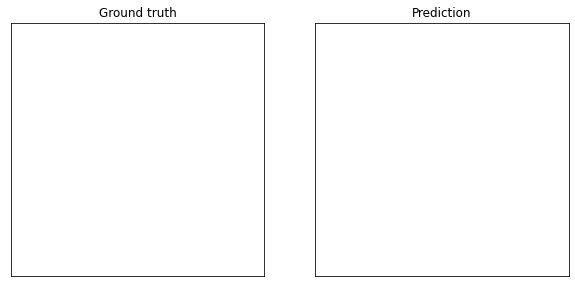

In [30]:
#writer = animation.PillowWriter(fps=30) 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_info = []
for ax_i, (label, rollout_field) in enumerate(
    [("Ground truth", "ground_truth_rollout"),
      ("Prediction", "predicted_rollout")]):
  # Append the initial positions to get the full trajectory.
  trajectory = np.concatenate([
      rollout_data["initial_positions"],
      rollout_data[rollout_field]], axis=0)
  ax = axes[ax_i]
  ax.set_title(label)
  bounds = rollout_data["metadata"]["bounds"]
  ax.set_xlim(bounds[0][0]-0.2, bounds[0][1]+0.2)
  ax.set_ylim(bounds[1][0]-0.2, bounds[1][1]+0.2)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect(1.)
  points = {
      particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
      for particle_type, color in TYPE_TO_COLOR.items()}
  plot_info.append((ax, trajectory, points))

num_steps = trajectory.shape[0]



In [31]:
trajectory.shape

(1000, 425, 2)

In [32]:
def update(step_i):
  outputs = []
  for _, trajectory, points in plot_info:
    for particle_type, line in points.items():
      mask = rollout_data["particle_types"] == particle_type
      line.set_data(trajectory[step_i, mask, 0],
                    trajectory[step_i, mask, 1])
      outputs.append(line)
  return outputs


In [33]:
result = update(0)

In [34]:
frames=np.arange(0, num_steps, step_stride)

In [35]:
animation_case = animation.FuncAnimation(fig,update,frames=frames, interval=5)

In [36]:
from IPython.display import HTML
HTML(animation_case.to_html5_video())